In [1]:
import pandas as pd
import numpy as np
import joblib
import glob
from math import sqrt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, shapiro

from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
import seaborn as sns
import pandas_profiling

# Single Variable Prediction

In [2]:
### Loading up Variables:
def load_individual_city_data(cityName, normalized=True):
    if normalized:
        return joblib.load("data/cleaned/normalized_{}.joblib".format(cityName))
    else:
        return joblib.load("data/cleaned/unnormalized_{}.joblib".format(cityName))

def load_full_dataset(normalized=True):
    if normalized:
        return joblib.load("data/cleaned/normalized_complete.joblib")
    else:
        return joblib.load("data/cleaned/unnormalized_complete.joblib")
    
def idx2CityName(idx):
    mapping = {0 : 'Aotizhongxin', 1 : 'Changping',
     2 : 'Dingling',3 : 'Dongsi', 4 : 'Guanyuan',
     5 : 'Gucheng', 6 : 'Huairou', 7 : 'Nongzhanguan',
     8 : 'Shunyi', 9 : 'Tiantan',10 : 'Wanliu',
    11 : 'Wanshouxigong'}

    return mapping[idx]

def cityName2Idx(cityName):
    mapping = {'Aotizhongxin' : 0, 'Changping' : 1, 'Dingling' : 2, 'Dongsi' : 3,
     'Guanyuan' : 4, 'Gucheng' : 5, 'Huairou' : 6, 'Nongzhanguan' : 7, 'Shunyi' : 8,
     'Tiantan' : 9, 'Wanliu' : 10, 'Wanshouxigong' : 11}
    
    return mapping[cityName]

def split(X, y):
    train_index = (0, 21000)
    validation_index = (21000, 28000)
    test_index = (28000, len(X) - 1)
    
    X_train, X_val, X_test = X[:train_index[1]], X[validation_index[0]:validation_index[1]], X[test_index[0]:]
    y_train, y_val, y_test = y[:train_index[1]], y[validation_index[0]:validation_index[1]], y[test_index[0]:]
    
    return X_train, X_val, X_test, y_train, y_val, y_test

def prepare(df, resp_col):
    cols = df.columns
    pred_cols = []
    for col in cols:
        if col != resp_col:
            pred_cols.append(col)
            
    
    pred_dataset = df[pred_cols]
    X = pred_dataset[pred_cols].values
    scaler = MinMaxScaler(feature_range=(-1, 1))
    X = scaler.fit_transform(X)
    
    series = df[resp_col].values
    values = series.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    y = scaler.fit_transform(values)
    
    return X, y

def perform_grid_search_cross_validation(model, X_train, y_train, grid_param, scoring='accuracy', cv=5, n_jobs=1):
    gd_sr = GridSearchCV(estimator=model, param_grid=grid_param, scoring=scoring, cv=cv, n_jobs=n_jobs)
    gd_sr.fit(X_train, y_train)
    return gd_sr.best_params_
    

def validate_prediction(y, y_pred):
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)

    return "mse = {mse} & mae = {mae} & rmse = {rmse}".format(mse=mse, mae=mae, rmse=sqrt(mse))

def get_scaler(dataset, feature_col="SO2"):
    dataset = dataset[[feature_col]]
    series = dataset[feature_col].values
    values = series.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    values = scaler.fit_transform(values)
    return scaler

### Pollutant: NO2

In [3]:
dataset = load_individual_city_data(idx2CityName(11), False)

In [4]:
no2_dataset = dataset.drop(['WSPM', 'E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE',
       'SSE', 'SSW', 'SW', 'W', 'WNW', 'PM2.5'], inplace=False, axis=1)

In [5]:
no2_dataset.columns

Index(['SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP'], dtype='object')

In [6]:
X, y = prepare(no2_dataset, "NO2")

In [7]:
X_train, X_val, X_test, y_train, y_val, y_test = split(X, y)

In [8]:
neigh = KNeighborsRegressor(algorithm='brute', n_neighbors=14, weights='distance', n_jobs=7)
neigh.fit(X_train, y_train)

KNeighborsRegressor(algorithm='brute', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=7, n_neighbors=14, p=2,
                    weights='distance')

In [10]:
y_pred = neigh.predict(X_val)

errors_on_train = validate_prediction(y_train, neigh.predict(X_train))
errors_on_val = validate_prediction(y_val, y_pred)
print("Train: {}".format(errors_on_train))
print("Validation: {}".format(errors_on_val))

Train: mse = 6.144294139649036e-09 & mae = 7.649646203863061e-07 & rmse = 7.838554802799453e-05
Validation: mse = 0.025186765248444057 & mae = 0.11733081716510313 & rmse = 0.15870338764010067


In [11]:
scaler_no2 = get_scaler(dataset, feature_col="NO2")
y_rescaled = scaler_no2.inverse_transform(y_pred)

In [12]:
joblib.dump(neigh, "data/model/knn_no2.joblib")

['data/model/knn_no2.joblib']

In [13]:
[x for x in range(12,20)]

[12, 13, 14, 15, 16, 17, 18, 19]

In [14]:
validate_prediction(y_pred, y_val)

'mse = 0.025186765248444057 & mae = 0.11733081716510313 & rmse = 0.15870338764010067'

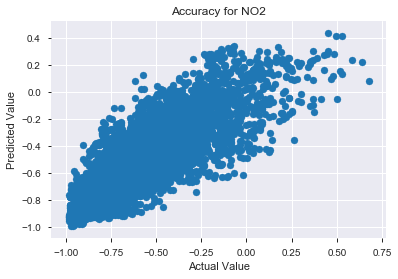

In [15]:
plt.scatter(y_val, y_pred)
plt.title("Accuracy for NO2")
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.show()

### Pollutant: PM2.5

In [27]:
pm25_dataset = dataset.drop(['WSPM', 'E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE',
       'SSE', 'SSW', 'SW', 'W', 'WNW', 'NO2'], inplace=False, axis=1)

In [28]:
X, y = prepare(pm25_dataset, "PM2.5")

In [29]:
X_train, X_val, X_test, y_train, y_val, y_test = split(X, y)

In [30]:
neigh = KNeighborsRegressor(algorithm='ball_tree', n_neighbors=14, weights='uniform', n_jobs=3)
neigh.fit(X_train, y_train)

KNeighborsRegressor(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=3, n_neighbors=14, p=2,
                    weights='uniform')

In [31]:
y_pred = neigh.predict(X_val)

In [32]:
joblib.dump(neigh, "data/model/knn_pm2.5.joblib")

['data/model/knn_pm2.5.joblib']

In [24]:
def get_scaler(dataset, feature_col="SO2"):
    dataset = dataset[[feature_col]]
    series = dataset[feature_col].values
    values = series.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    values = scaler.fit_transform(values)
    return scaler

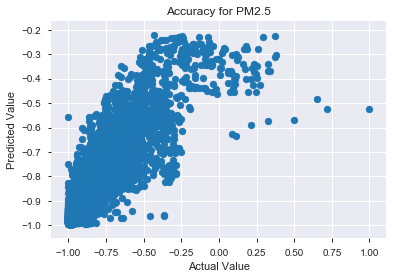

In [33]:
plt.scatter(y_val, y_pred)
plt.title("Accuracy for PM2.5")
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.show()